In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from windrose import WindroseAxes
from matplotlib.dates import date2num
from utide import solve, reconstruct
import numpy as np
import pandas as pd
from windrose import WindroseAxes
import scipy as sp
import hvplot.xarray
from eofs.xarray import Eof
import glob
from statsmodels.tsa.stattools import acf
from hampel import hampel # for outlier removal
#import sktime as sk

## GOM background

In [7]:
path='GOM/Figures and data GOM risk and wells/Data/'
try:
    GOMECC=pd.read_excel(path + 'GOMECC_USF_DIC_UW.xls').rename(columns={'GMT':'time'}).set_index('time').to_xarray()

    DICts=GOMECC.DIC.where(GOMECC.DIC>0,np.nan).interpolate_na(dim='time')
    DICts.to_netcdf('To_Parisa/GOMEC_ts.nc')
except:
    DICts=xr.open_dataset('GOMEC_ts.nc')

DICts

In [250]:
DICts.to_netcdf('To_Parisa/GOMEC_ts.nc')

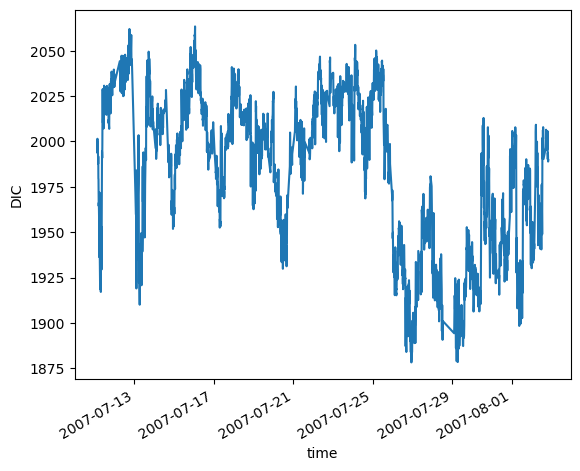

In [10]:
DICts.plot()

In [245]:
DICts.mean(dim='time')

<xarray.DataArray 'DIC' ()>
array(1984.81630719)

In [246]:
DICts.var(dim='time')

<xarray.DataArray 'DIC' ()>
array(1750.45051547)

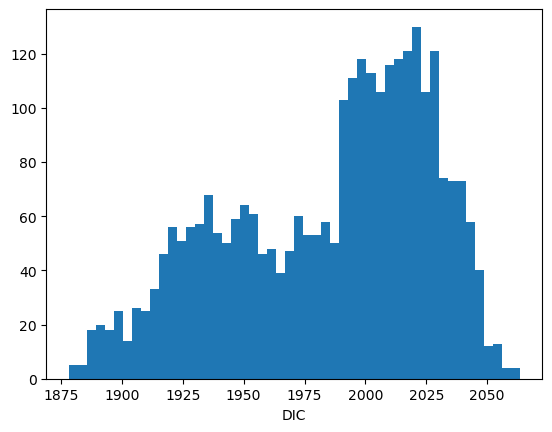

In [247]:
DICts.plot.hist(bins=50)
plt.show()

## single sources from ACTOM toolbox

In [226]:
def read_one(filenm='Temp_data/statistics_24.nc',verbose=False):
    if verbose:
        print('Open: '+ filenm)
    stats=xr.open_dataset(filenm)

    indx=stats['mean'].argmax(dim=['x','y'])
    
    #mxs=inarr.isel(x=indx['x'],y=indx['y'])
    stats['xs']=stats.x-stats.x.isel(x=indx['x'])   
    stats['ys']=stats.y-stats.y.isel(y=indx['y'])
    stats['r']=np.sqrt(stats.xs**2+stats.ys**2)
    stats= stats.assign_coords(r=stats.r)
    stats= stats.assign_coords(xs=stats.xs)
    stats= stats.assign_coords(ys=stats.ys)
    #stats=stats.stack(z=['x','y'])
    stata=stats.stack(z=['x','y']).groupby_bins('r', np.r_[0:3000:10]).mean(skipna=True)
    return stata

In [253]:

files=glob.glob(path + 'statistics_*[0-99].nc')
all_stat=[]
for file in files:
    #print(file)
    all_stat.append(read_one(filenm=file,verbose=False))

all_stat=xr.concat(all_stat,dim='source')
all_stat=all_stat.assign_coords(r=('r_bins',np.asarray([v.mid for v in all_stat['r_bins'].values] ))).drop('r_bins')
    

In [254]:
all_stat

<xarray.Dataset>
Dimensions:         (dt: 3, source: 75, r_bins: 299)
Coordinates:
  * dt              (dt) float64 900.0 1.8e+03 3.6e+03
    r               (r_bins) float64 5.0 15.0 25.0 ... 2.975e+03 2.985e+03
Dimensions without coordinates: source, r_bins
Data variables:
    mean            (source, r_bins) float64 0.2491 0.2 ... 0.0007001 0.0007138
    var             (source, r_bins) float64 0.09631 0.08798 ... 8.475e-06
    max             (source, r_bins) float64 1.637 1.589 ... 0.008131 0.009049
    delta_mean      (source, r_bins, dt) float64 8.928e-05 ... 3.459e-06
    delta_mean_abs  (source, r_bins, dt) float64 0.01338 0.0264 ... 0.0002074
    delta_var       (source, r_bins, dt) float64 0.002327 0.008762 ... 7.139e-07
    delta_max       (source, r_bins, dt) float64 0.4838 0.8667 ... 0.002254
    delta_min       (source, r_bins, dt) float64 -0.3289 -0.6056 ... -0.00236
Attributes: (12/33)
    max_prob:              0.0007019417826086283
    sum_prob:              1.2551407
    risk file:             ar56.8928.bm1310.slp3d.migration_conv_AGF_1_netcdf.nc
    threshold:             0.1
    cluster:               dbscan
    Probe file:            Indata/Probes/Probes_ar56_ex3.nc
    ...                    ...
    Fill type:             nearest extrapolation
    Downsampling:          False
    Downsampling factor:   16.0
    source tag:            0
    Origin:                [ 292901.5625 3207124.    ]
    location_probability:  21.8597

In [255]:
stata=all_stat.mean(dim='source')
stata.to_netcdf('To_Parisa/statistics.nc')

In [257]:
stata.isel(r_bins=0)

<xarray.Dataset>
Dimensions:         (dt: 3)
Coordinates:
  * dt              (dt) float64 900.0 1.8e+03 3.6e+03
    r               float64 5.0
Data variables:
    mean            float64 0.2479
    var             float64 0.1178
    max             float64 1.81
    delta_mean      (dt) float64 0.0002899 0.0005798 0.00116
    delta_mean_abs  (dt) float64 0.01221 0.02422 0.04708
    delta_var       (dt) float64 0.002141 0.008013 0.02633
    delta_max       (dt) float64 0.3527 0.6073 0.8684
    delta_min       (dt) float64 -0.2314 -0.4311 -0.7235

In [236]:
stata['mean'].isel(r_bins=0)

<xarray.DataArray 'mean' ()>
array(0.24789795)
Coordinates:
    r        float64 5.0

## Scaling 


In [261]:
Z_alpha=1.96 
Z_beta=0.84
sigma=41 # from Gomecc.
N_center=1 # number of measurements needed 
at_r_bin=3 # at r_bin

scaling=((Z_alpha+Z_beta)*sigma/np.sqrt(N_center))/stata['mean'].isel(r_bins=at_r_bin)
scaling

<xarray.DataArray 'mean' ()>
array(1135.46668002)
Coordinates:
    r        float64 35.0

### Plotting the resulting scaled $\Delta \mu (r)$

(0.0, 500.0)

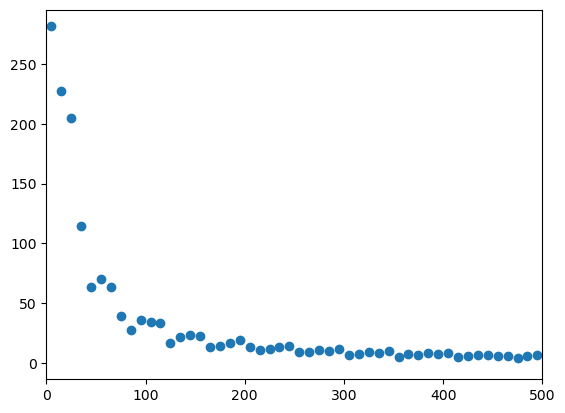

In [262]:
plt.scatter(x=stata.r,y=scaling.values*stata['mean'])
plt.xlim(0,500)

Calculating the resulting needed measurements
$$
N= \left(\frac{Z_\alpha+Z_\beta}{\frac{\Delta \mu (r)}{\sigma}}\right)^2
$$

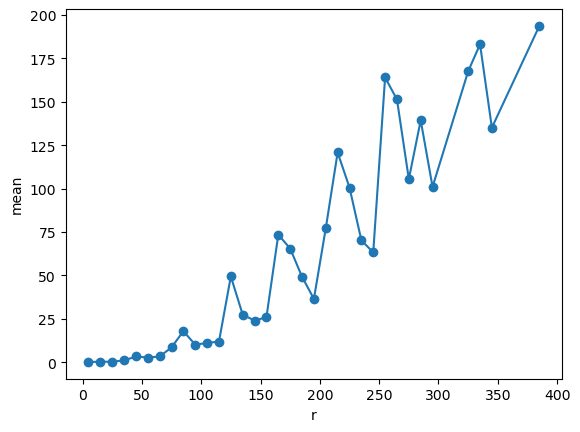

In [265]:
N_meas=(Z_alpha+Z_beta)**2/(scaling.values*stata['mean']/sigma)**2
N_meas.where(N_meas<200,drop=True).plot(x='r',marker='o')

In [266]:
N_meas[0:10]

<xarray.DataArray 'mean' (r_bins: 10)>
array([ 0.1663371 ,  0.25488275,  0.31314653,  1.        ,  3.2962339 ,
        2.67123336,  3.29572642,  8.52119383, 17.8681762 , 10.12577218])
Coordinates:
    r        (r_bins) float64 5.0 15.0 25.0 35.0 45.0 55.0 65.0 75.0 85.0 95.0
Dimensions without coordinates: r_bins

Least square

<AxesSubplot:>

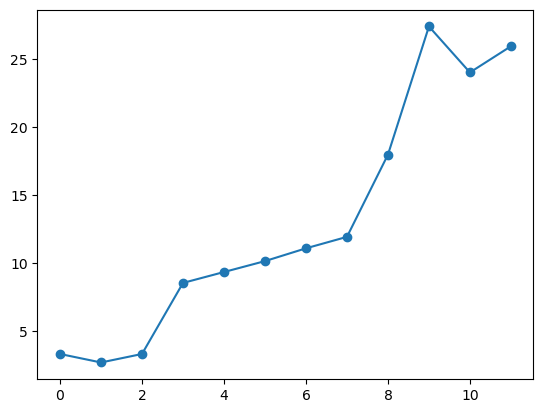

In [269]:
r_up=160
r_dwn=40
y=N_meas.where((N_meas.r<r_up) & (N_meas.r>r_dwn),drop=True)
x=y.r.values

# remove outliers
num=hampel(pd.Series(y.values), window_size=3, n=1, imputation=True)
num.plot(marker='o')
#plt.scatter(x=x,y=num)

In [270]:
A = np.vstack([x, np.ones(len(x))]).T

# turn y into a column vector
y = num#[:, np.newaxis]
alpha = np.dot((np.dot(np.linalg.inv(np.dot(A.T,A)),A.T)),y.T)
print(alpha)
yn=alpha[0]*x + alpha[1]

[  0.2326298  -10.30737038]


In [271]:
alpha[1]/alpha[0]

-44.30803944587786

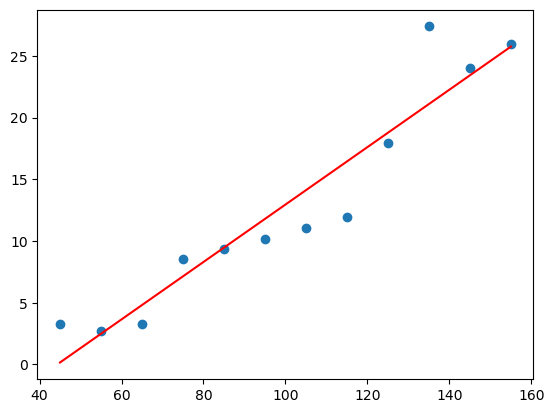

In [272]:
plt.plot(x,yn,'r')
plt.scatter(x,y)

## Bayes


In [140]:
DICts

<xarray.DataArray 'DIC' (time: 2879)>
array([1998.48682634, 2001.48913306, 1993.58459952, ..., 1992.46619235,
       1988.93384105, 1989.77586562])
Coordinates:
  * time     (time) datetime64[ns] 2007-07-11T03:38:30 ... 2007-08-02T20:00:49

In [141]:
sigma=DICts.std(dim='time')
sigma

<xarray.DataArray 'DIC' ()>
array(41.83838567)

In [142]:
p0=0.01
q=0.95
alpha=p0*(1-q)/q/(1-p0)
np.log(alpha)

-7.539558829301029

In [143]:
stata

<xarray.Dataset>
Dimensions:         (dt: 3, r_bins: 299)
Coordinates:
  * dt              (dt) float64 900.0 1.8e+03 3.6e+03
  * r_bins          (r_bins) object (0, 10] (10, 20] ... (2980, 2990]
    r               (r_bins) float64 5.0 15.0 25.0 ... 2.975e+03 2.985e+03
Data variables:
    mean            (r_bins) float64 0.2479 0.2003 ... 0.0006695 0.0007789
    var             (r_bins) float64 0.1178 0.09376 ... 7.004e-06 8.776e-06
    max             (r_bins) float64 1.81 1.548 1.407 ... 0.008638 0.009505
    delta_mean      (r_bins, dt) float64 0.0002899 0.0005798 ... 5.35e-06
    delta_mean_abs  (r_bins, dt) float64 0.01221 0.02422 ... 0.0001069 0.000212
    delta_var       (r_bins, dt) float64 0.002141 0.008013 ... 8.957e-07
    delta_max       (r_bins, dt) float64 0.3527 0.6073 ... 0.00149 0.002826
    delta_min       (r_bins, dt) float64 -0.2314 -0.4311 ... -0.001282 -0.00246

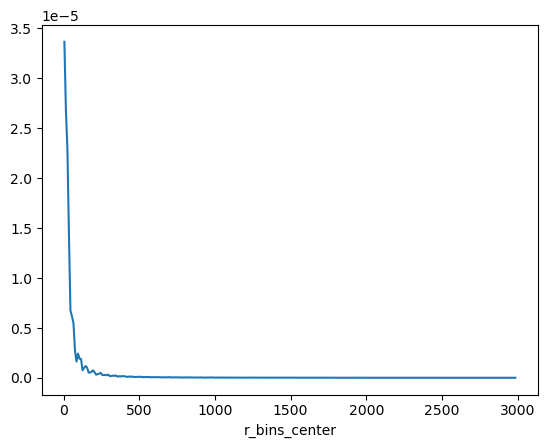

In [144]:
np.log(np.sqrt(1+stata['var']/sigma**2)).plot()

In [145]:
scale=400/stata['mean'].max()

In [146]:
Delta=scale*stata['mean']
sigma_D=scale*np.sqrt(stata['var'])

In [147]:
sigma_D

<xarray.DataArray (r_bins: 299)>
array([553.71677149, 494.08663074, 456.88680089, 362.08995549,
       247.62953315, 236.97441862, 223.26320987, 157.52037088,
       121.77915222, 148.51733017, 132.05932466, 131.33305192,
        82.87371288,  95.03276566, 103.77343121,  96.49937548,
        68.82202673,  69.47222153,  74.64800121,  82.35797187,
        69.93823689,  53.14208731,  57.59441936,  61.67332154,
        66.84392041,  51.14302778,  49.25571619,  51.70933488,
        48.05440993,  53.41795805,  39.37862188,  40.21739564,
        44.50593926,  41.80627256,  46.26469768,  32.35988521,
        39.15787315,  34.00318149,  39.86561117,  36.91181263,
        38.13792512,  29.66702904,  29.71285027,  33.79028341,
        33.8075339 ,  30.0065216 ,  30.02853049,  25.25924528,
        28.25119192,  31.06445906,  27.68952975,  30.99109371,
        23.22075738,  26.49688205,  25.08906598,  27.43848652,
        26.22707673,  25.65880863,  21.51614449,  24.617673  ,
        21.39063426,  25.52889162,  24.55125818,  22.67330905,
        19.96259513,  21.80372781,  22.29009261,  19.91590222,
        21.88615748,  22.37719613,  24.1380946 ,  16.45298224,
        19.3511764 ,  21.15517794,  19.15182035,  19.79341318,
        20.35327276,  19.30176012,  15.81083247,  17.59078932,
...
         6.61201142,   4.7538168 ,   6.08799486,   6.61307886,
         5.69050742,   7.20322436,   6.64329043,   7.24589204,
         5.85847484,   5.72739139,   7.04199123,   6.38440962,
         7.24501987,   7.73826213,   4.93937761,   5.72954919,
         6.23260497,   5.50768323,   5.69775217,   6.03685404,
         5.5707552 ,   5.4223734 ,   5.86189877,   6.51597188,
         7.22738936,   6.31953798,   7.34319298,   5.89921736,
         4.23809832,   4.8585807 ,   4.72308695,   5.26122258,
         5.34999825,   5.13327004,   6.7260602 ,   6.0385954 ,
         5.8783891 ,   6.91561336,   6.5955458 ,   6.04051119,
         5.81892239,   6.34991515,   3.30567584,   4.42980998,
         4.66298638,   5.23438501,   6.39825543,   6.32491249,
         5.56804941,   6.23416408,   5.19584308,   6.10580993,
         5.59927446,   5.56709969,   5.86513336,   4.98168301,
         5.50212018,   3.29751333,   5.58601198,   4.98129247,
         5.76065538,   5.61493437,   5.52790356,   5.15459166,
         4.34561943,   5.33824303,   3.95675856,   5.18472737,
         5.33807996,   4.93742634,   5.91340625,   5.92442493,
         3.74461245,   4.48328466,   5.24098932,   4.60404854,
         5.08948059,   4.27032489,   4.78008694])
Coordinates:
  * r_bins   (r_bins) object (0, 10] (10, 20] ... (2970, 2980] (2980, 2990]
    r        (r_bins) float64 5.0 15.0 25.0 ... 2.965e+03 2.975e+03 2.985e+03

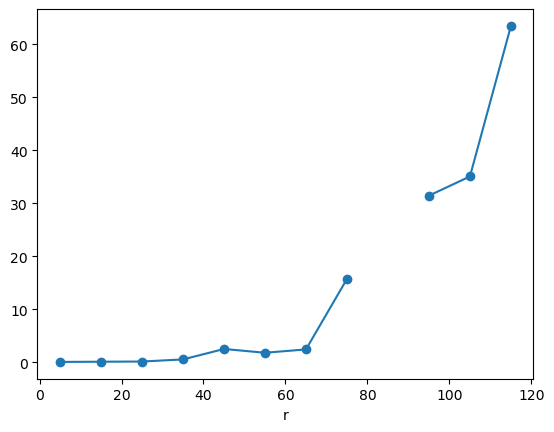

In [148]:
N_res=(np.log(alpha)/(np.log(np.sqrt(1+sigma_D**2/41**2))-(Delta/41)**2))
N_res.where(N_res>0).plot(x='r',marker='o')

In [74]:
np.log(np.sqrt(1+sigma_D**2/41**2)).min()

<xarray.DataArray 'mean' ()>
array(0.21488923)

In [75]:
A=np.log(np.sqrt(1+sigma_D**2/41**2))
B=(Delta/41)**2

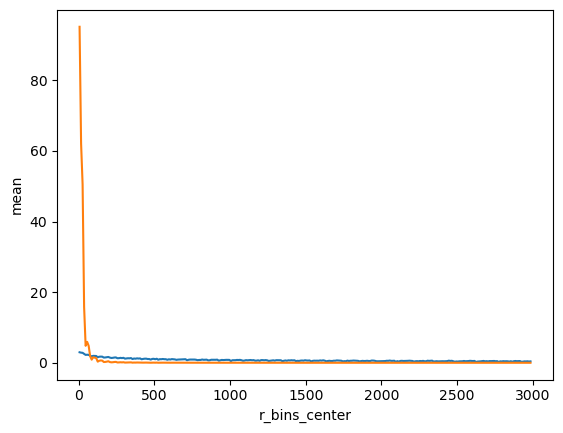

In [76]:
A.plot()
B.plot()

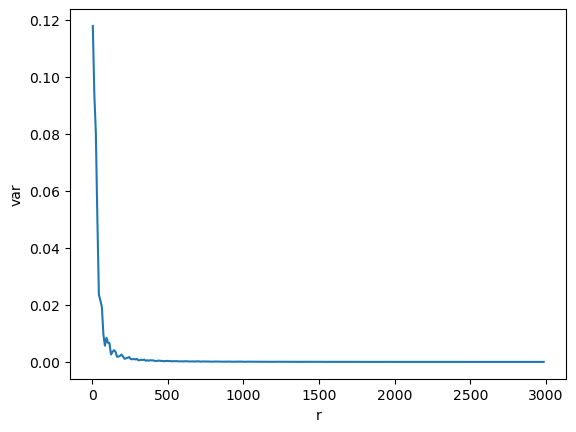

In [77]:
stata['var'].plot(x='r')

In [78]:
GOMECC

<xarray.Dataset>
Dimensions:        (time: 2879)
Coordinates:
  * time           (time) datetime64[ns] 2007-07-11T03:38:30 ... 2007-08-02T2...
Data variables:
    Latitude       (time) object '2859.8631N' '2859.8617N' ... '3738.2554N'
    Longitude      (time) object '09459.9804W' '09459.9787W' ... '06825.0758W'
    TSG-Unit-Temp  (time) float64 29.11 29.1 29.09 29.09 ... 29.46 29.53 29.41
    MicroSal       (time) float64 30.16 30.15 30.15 30.11 ... 36.07 36.08 36.08
    DIC            (time) float64 1.998e+03 2.001e+03 ... 1.989e+03 1.99e+03
    fCO2           (time) float64 -999.0 -999.0 -999.0 ... -999.0 402.9 401.1

## STEMM

In [3]:
stemm=xr.open_dataset('../../STEMM_CCS/Data/pos534.nc')
devel_l=xr.open_dataset('../../STEMM_CCS/Data/develogic_long.nc')
devel_h=xr.open_dataset('../../STEMM_CCS/Data/develogic_high.nc')
JC180=xr.open_dataset('../../STEMM_CCS/Data/JC180_chemistry.nc')

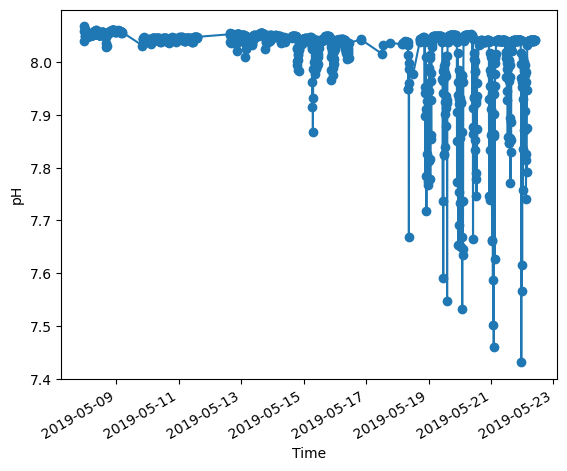

In [15]:
JC180.pH.plot(marker='o')

In [281]:
JC180.Time

<xarray.DataArray 'Time' (Time: 1523)>
array(['2019-05-07T23:05:22.000000000', '2019-05-07T23:15:05.000000000',
       '2019-05-07T23:24:49.000000000', ..., '2019-05-22T09:22:12.000000000',
       '2019-05-22T09:31:59.000000000', '2019-05-22T09:41:45.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * Time     (Time) datetime64[ns] 2019-05-07T23:05:22 ... 2019-05-22T09:41:45

In [95]:
quarter=stemm.resample(Time='0.25H').interpolate()


In [96]:
qjc180

<xarray.Dataset>
Dimensions:    (index: 2323)
Coordinates:
  * index      (index) datetime64[ns] 2019-04-27T12:00:00 ... 2019-05-21T16:3...
Data variables:
    vE         (index) float64 0.098 -0.057 -0.148 ... -0.08 0.0195 0.005
    vN         (index) float64 0.015 0.076 0.045 ... -0.015 -0.1135 -0.032
    Speed      (index) float64 0.099 0.1045 0.155 0.09 ... 0.081 0.1485 0.032
    Direction  (index) float64 81.3 317.8 286.9 177.4 ... 259.4 173.8 171.1
    Pressure   (index) float64 2.941 4.147 4.659 105.7 ... 0.433 0.2475 0.092
    tide_u     (index) float64 -0.02211 -0.02256 -0.02305 ... 0.03564 0.03548
    tide_v     (index) float64 0.141 0.1335 0.1246 ... 0.02783 0.06353 0.09807
    rem_u      (index) float64 0.1201 -0.03444 -0.125 ... -0.01614 -0.03048
    rem_v      (index) float64 -0.126 -0.05748 -0.07965 ... -0.177 -0.1301

In [81]:
quarter.pCO2.mean(dim='Time')

<xarray.DataArray 'pCO2' ()>
array(442.6532925)

In [82]:
quarter.pCO2.diff(dim='Time').std()

<xarray.DataArray 'pCO2' ()>
array(0.25676337)

In [83]:
stata['delta_mean'].max()

<xarray.DataArray 'delta_mean' ()>
array(0.00115969)

In [87]:
quarter.pCO2.mean(dim='Time')

<xarray.DataArray 'pCO2' ()>
array(442.6532925)

In [88]:
quarter.pCO2.std(dim='Time')

<xarray.DataArray 'pCO2' ()>
array(2.09598399)

(array([ 14.,  42.,  98., 422., 275., 259., 283.,  31.,  21.,   7.]),
 array([-0.0061 , -0.00479, -0.00348, -0.00217, -0.00086,  0.00045,
         0.00176,  0.00307,  0.00438,  0.00569,  0.007  ]),
 <BarContainer object of 10 artists>)

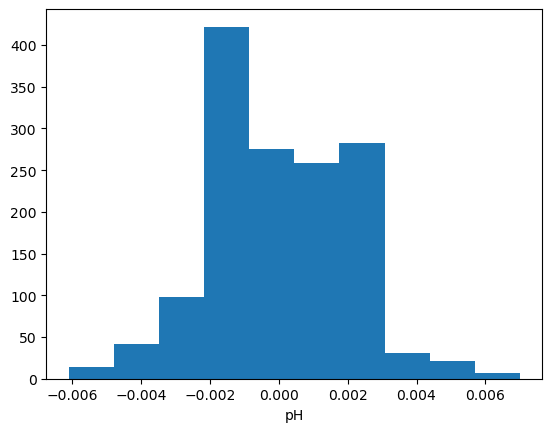

In [104]:
quarter.pH.diff(dim='Time').plot.hist(bins=10)